# Text based item search
_**Using a pretrained BERT and Elasticsearch KNN to search textually similar items**_

---

---

## Contents


1. [Background](#Background)
1. [Setup](#Setup)
1. [Lauange Translation](#Trnslate)
1. [SageMaker Model Hosting](#Hosting-Model)
1. [Build a KNN Index in Elasticsearch](#ES-KNN)
1. [Evaluate Index Search Results](#Searching-with-ES-k-NN)
1. [Extensions](#Extensions)

## Background

In this notebook, we'll build the core components of a textually similar items search. Sometime people don't know what exactly they are looking in that case they just type an item descriptions and it will retrive the similar items.

One of the core components of textually similar items search is a fixed length sentence/word embedding i,e a  “feature vectors” corrosponds to that text. The reference word/sentence embedding typically are generated offline and must be stored in. So they can be efficiently searched. So generating word/sengtence embedding can be achived by pretrained language model such as BRET(Bidirectional Encoder Representations from Transformers). In our use case we have used pretrained sentence-transformers(https://github.com/UKPLab/sentence-transformers).

To enable efficient searches for textually similar items, we'll use Amazon SageMaker to generate fixed length sentence embedding i.e “feature vectors” and use KNN algorithim in Amazon Elasticsearch service. KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance. Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

Here are the steps we'll follow to build textually similar items: After some initial setup, we'll host the pretrained BERT language model in SageMaker PyTorch model server. Then generate feature vectors for Multi-modal Corpus of Fashion Images from *__feidegger__*, a *__zalandoresearch__* dataset. Those feature vectors will be imported in Amazon Elasticsearch KNN Index. Next, we'll explore some sample text queries, and visualize the results.

## Setup

Prerequisite for this workshop:

1. **Downloading Zalando Research data**: Data originally from here: https://github.com/zalandoresearch/feidegger 

    **Citation:** <br>
 *@inproceedings{lefakis2018feidegger,* <br>
 *title={FEIDEGGER: A Multi-modal Corpus of Fashion Images and Descriptions in German},* <br>
 *author={Lefakis, Leonidas and Akbik, Alan and Vollgraf, Roland},* <br>
 *booktitle = {{LREC} 2018, 11th Language Resources and Evaluation Conference},* <br>
 *year      = {2018}* <br>
 *}*
 
1. **Create S3 bucket**: Create an Amazon S3 bucket on the same region as the SageMaker Notebook Instance. This bucket will store all the *__feidegger__* fashion dataset
1. **Setup IAM role**: Create a IAM role with *__AmazonSageMakerFullAccess__* and also create an inline policy to have *__GetObject__* & *__PutObject__* permission on the bucket
1. **Prepare the dataset**: Upload the  *__feidegger__* fashion dataset dataset in S3 bucket
1. **Create Amazon Elasticsearch domain**: Create an Amason Elasticsearch domain with version 7.1 or later
1. **Configure Amazon Elasticsearch domain**: Do the IAM role mapping in Amazon Elasticsearch using Kibana endpoint.


### Downloading Zalando Research data

The dataset itself consists of 8732 high-resolution images, each depicting a dress from the available on the Zalando shop against a white-background. Each of the images has five textual annotations in German, each of which has been generated by a separate user. 

In [4]:
import os
images_path = 'data/feidegger/fashion'
filename = 'metadata.json'
if not os.path.isdir(images_path):
    os.makedirs(images_path)


In [5]:
#Download the metadata.json file that contains the URL of the images and German product descriptions
import urllib.request

#download metadata.json to local notebook
def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        
download_metadata('https://raw.githubusercontent.com/zalandoresearch/feidegger/master/data/FEIDEGGER_release_1.1.json')

In [6]:
#installing progress bar
!pip install tqdm

    100% |████████████████████████████████| 71kB 10.5MB/s ta 0:00:01
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
#defining image download function
import json
import tqdm
from tqdm import notebook

def generate_image_list(filename):
    metadata = open(filename,'r')
    data = json.load(metadata)
    url_lst = []
    for i in range(len(data)):
        url_lst.append(data[i]['url'])
    return url_lst


def download_image(url_lst):
        for i in tqdm.notebook.tqdm(range(len(url_lst))):
            urllib.request.urlretrieve(url_lst[i], images_path + '/' + url_lst[i].split("/")[-1])

In [ ]:
#Downloading the images. This process will take around ~1 hr.

import time
start_time = time.time()
url_lst = generate_image_list(filename)
download_image(url_lst)
elapsed_time = time.time() - start_time
elapsed_time

In [11]:
# Importing necessary library
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()


In [12]:
# Uploading dataset to S3
dirName = 'data'
def upload_to_s3(bucket, file):
    s3_resource = boto3.resource("s3")
    my_bucket = s3_resource.Bucket(bucket)
    for path, subdirs, files in os.walk('./' + dirName):
        path = path.replace("\\","/")
        directory_name = path.replace('./',"")
        for file in files:
            my_bucket.upload_file(os.path.join(path, file), directory_name+'/'+file)

In [ ]:
bucket = 'zalando-dataset' # put your own bucket name
upload_to_s3(bucket, 'data') # this process will take ~15 min to upload all the dataset to S3

## Lauange Translation

This dataset has product descriptions in German, So we will use Amazon Translate for English translation for each German sentence.

In [14]:
with open(filename) as json_file:
    data = json.load(json_file)

In [15]:
#Define translator function
def translate_txt(data):
    en_txt = []
    filename = []
    translate = boto3.client(service_name='translate', use_ssl=True)
    for i in tqdm.notebook.tqdm(range(len(data))):
        for j in range(len(data[i]['descriptions'])):
            result = translate.translate_text(Text=str(data[i]['descriptions'][j]), 
                    SourceLanguageCode="de", TargetLanguageCode="en")
            en_txt.append(result['TranslatedText'])
            filename.append('s3://zalando-dataset/data/feidegger/fashion/' + data[i]['url'].split("/")[-1])
    return filename,en_txt

In [ ]:
#calling the function
# we are using realtime traslation which will take around ~2.5 hrs. You can use Batch Translation to optmize 
start_time = time.time()
result = translate_txt(data)
elapsed_time = time.time() - start_time
elapsed_time

In [ ]:
# Saving the translated text in json in case you need later time
ziped = zip (result[0], result[1])
with open('zalando-translated-data.json', 'w', encoding='utf-8') as f:
    json.dump(list(ziped), f, ensure_ascii=False, indent=4)


## SageMaker Model Hosting

In this section will host the pretrained BERT model into SageMaker Pytorch model server to generte fixed length sentecce embedding from sentence-transformers. 

**Citation:** <br>
    @inproceedings{reimers-2019-sentence-bert,<br>
    title = "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks",<br>
    author = "Reimers, Nils and Gurevych, Iryna",<br>
    booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing",<br>
    month = "11",<br>
    year = "2019",<br>
    publisher = "Association for Computational Linguistics",<br>
    url = "http://arxiv.org/abs/1908.10084",<br>
}

In [ ]:
!pip install -U sentence-transformers

In [ ]:
#Save the model to disk which we will host at sagemaker
from sentence_transformers import models, SentenceTransformer
saved_model_dir = 'transformer'
if not os.path.isdir(saved_model_dir):
    os.makedirs(saved_model_dir)

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
model.save(saved_model_dir)

In [ ]:
#Defining defalut bucket for SageMaker pretrained model hosting
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/text-based-image-search'

role = sagemaker.get_execution_role()

In [ ]:
#zip the model .gz format
import tarfile
export_dir = 'transformer'
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add(export_dir, recursive=True)

In [ ]:
#Upload the model to S3

inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')
inputs

First we need to create a PyTorchModel object. The deploy() method on the model object creates an endpoint which serves prediction requests in real-time. If the instance_type is set to a SageMaker instance type (e.g. ml.m5.large) then the model will be deployed on SageMaker. If the instance_type parameter is set to *__local__* then it will be deployed locally as a Docker container and ready for testing locally.

First we need to create a RealTimePredictor class to accept TEXT as input and output JSON. The default behaviour is to accept a numpy array.

In [ ]:
class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')
           

In [ ]:
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import RealTimePredictor
from sagemaker import get_execution_role

role = get_execution_role() 

pytorch_model = PyTorchModel(model_data = inputs, 
                             role=role, 
                             entry_point ='inference.py',
                             source_dir = './code', 
                             framework_version = '1.3.1',
                             predictor_cls=StringPredictor)

predictor = pytorch_model.deploy(instance_type='ml.m5.large', initial_instance_count=1)


sentence transformer uses BERT pretrained model so it will generate 768 dimension for the given text. we will quickly validate the same in next cell.

In [ ]:
import json
payload = 'denim dress'
features = predictor.predict(payload)
embading = json.loads(features)

len(embading)


## Build a KNN Index in Elasticsearch

KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance. Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

KNN requires Elasticsearch 7.1 or later. Full documentation for the Elasticsearch feature, including descriptions of settings and statistics, is available in the Open Distro for Elasticsearch documentation. For background information about the k-nearest neighbors algorithm

In this step we'll get all the translated product descriptions of *__zalandoresearch__* dataset and import those embadings into Elastichseach7.4 domain.

In [ ]:
#install necessary pkg to make connection with elasticsearch domain
! pip install elasticsearch
! pip install requests
! pip install requests-aws4auth

In [21]:
# setting up the Elasticsearch connection
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
host = 'search-knndomain-ztdb23l3rfnsgacqgbisorrz5i.us-east-1.es.amazonaws.com' # For example, my-test-domain.us-east-1.es.amazonaws.com
region = 'us-east-1' # e.g. us-east-1
service = 'es'
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service, session_token=credentials.token)

es = Elasticsearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)

In [ ]:
#KNN index maping
knn_index = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
           "zalando_vector": {
                "type": "knn_vector",
                "dimension": 768
            } 
        }
    }
}

In [ ]:
#creating the Elasticsearch index
es.indices.create(index="idx_zalando",body=knn_index,ignore=400)

In [ ]:
# defining a function to port the feature vector into Elasticsearch index
# This process will take around 3 min.
def es_import():
    for i in tqdm.notebook.tqdm(range(len(result[0]))):
        vectors = model.encode([result[1][i]])
        es.index(
                 index='idx_zalando',
                 body={"zalando_vector": vectors[0].tolist(), 
                       "image": result[0][i]})


In [ ]:
#importing the index into ES. This process will take around ~15 min
import time
start_time = time.time()
es_import()
elapsed_time = time.time() - start_time
elapsed_time

## Evaluate Index Search Results

In this step we will use SageMaker SDK as well as Boto3 SDK to query the Elasticsearch to retrive the nearest neighbours.

In [17]:
#define display_image function
from PIL import Image
import io
def display_image(bucket, key):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket)
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    img = Image.open(file_stream)
    return display(img)

###### SageMaker SDK Method

In [18]:
#SageMaker SDK approach
import json
payload = 'yellow dress'
features = predictor.predict(payload)
embading = json.loads(features)

NameError: name 'predictor' is not defined

In [ ]:
#ES index search
import json
k = 3
idx_name = 'idx_zalando'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'zalando_vector': {'vector': embading, 'k': k}}}})


In [ ]:
#Display the image
bucket = 'zalando-dataset' # <Define your own bucket>

for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace('s3://zalando-dataset/','')
    img = display_image (bucket,key)

## Boto3 Method

In [25]:
#calling SageMaker Endpoint
client = boto3.client('sagemaker-runtime')
payload = 'denim dress'
ENDPOINT_NAME = 'pytorch-inference-2020-05-11-15-30-30-105' # Example'tensorflow-inference-2020-04-27-17-19-09-737'
response = client.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='text/plain',
                                       Body=payload)

response_body = json.loads((response['Body'].read()))


In [26]:
#ES index search
import json
k = 3
idx_name = 'idx_zalando'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'zalando_vector': {'vector': response_body, 'k': k}}}})

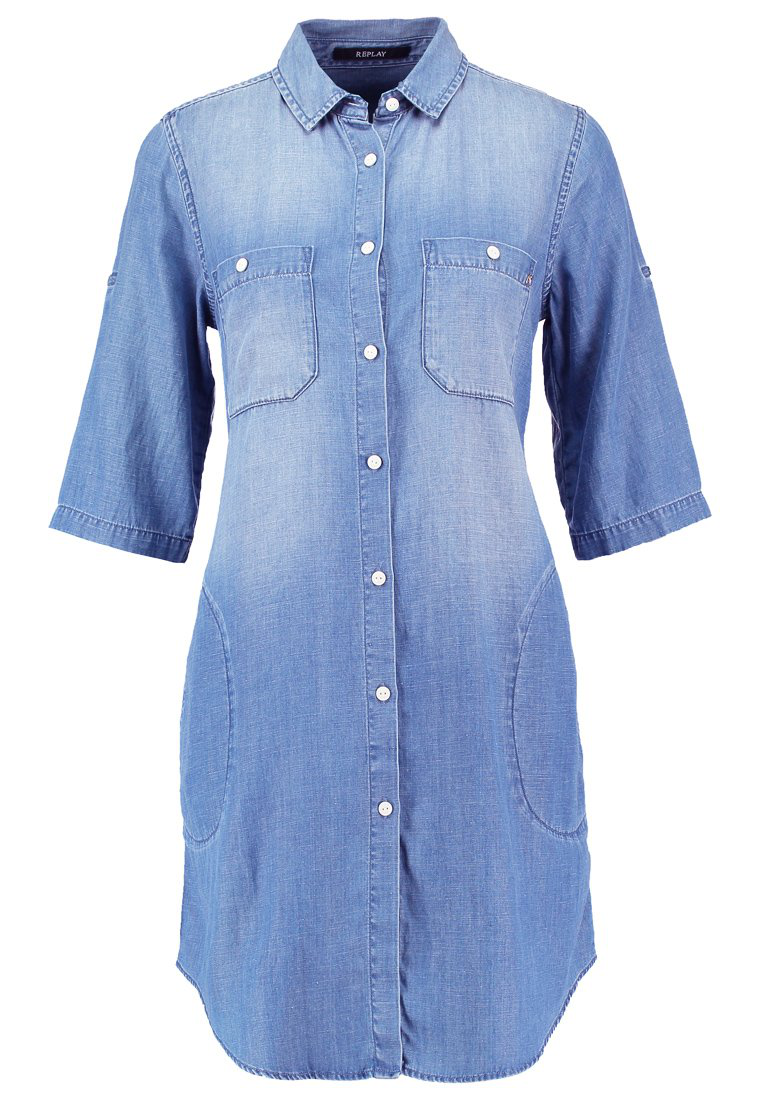

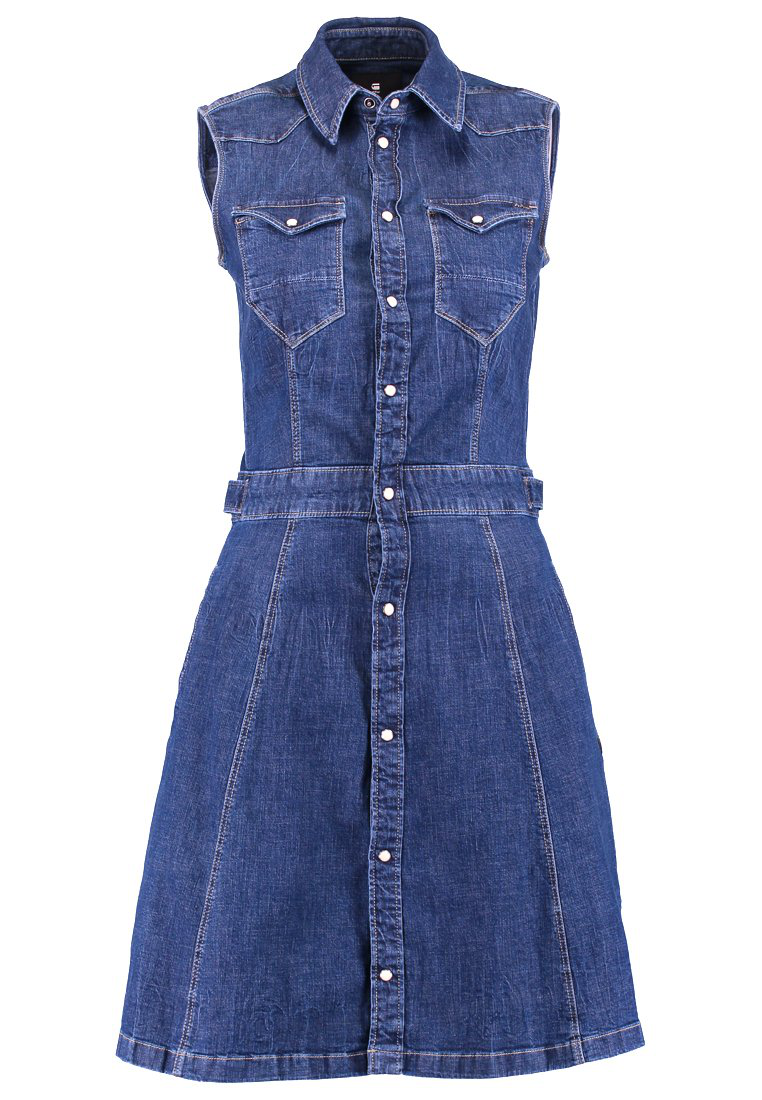

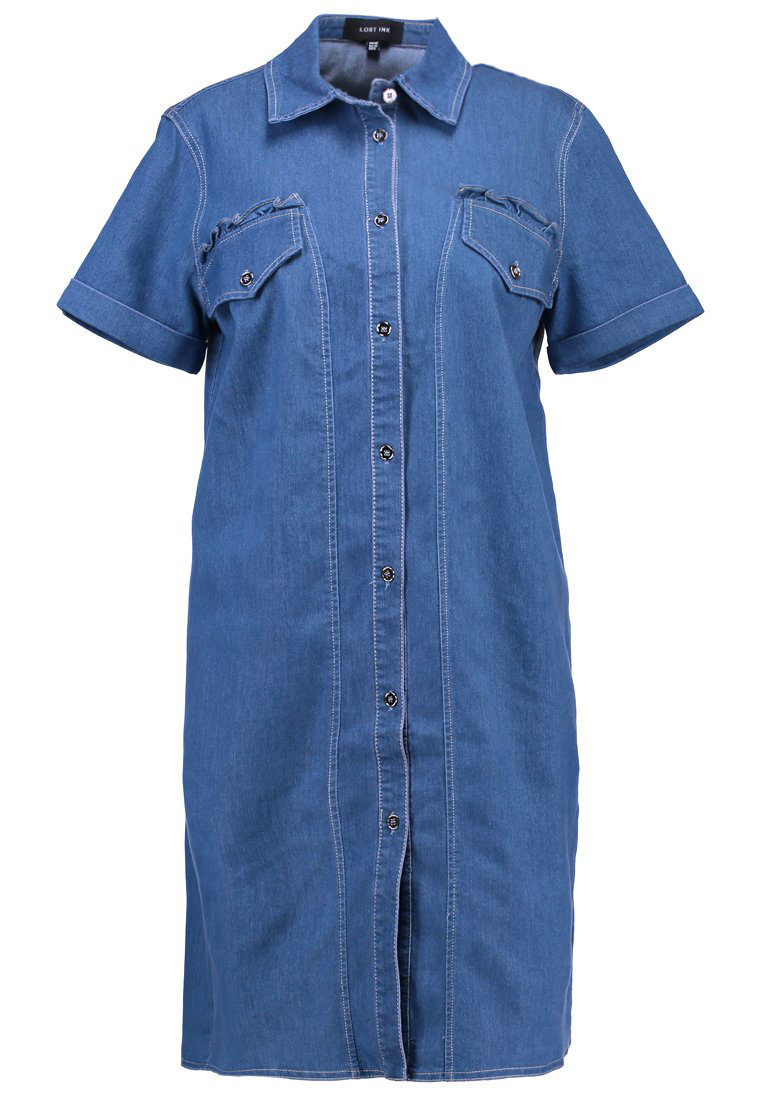

In [27]:
#Display the image
bucket = 'zalando-dataset'

for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace('s3://zalando-dataset/','')
    img = display_image (bucket,key)

## Extensions

We have used pretrained BERT model from sentence-transformers.Now if you have very specific domain specific problem then you need to tune the sentence-transformers model with your own data using transfer learning. For detail implementaion of fine tuning please check https://github.com/UKPLab/sentence-transformers.

You can also 
Once you have this kind of visual content based recommmender system implemented for your website then you can collect all the click stream data to have more robust collaborative filtering based recommender system using **Amazon Personalize**.

### Cleanup

Make sure that you stop the notebook instance, delete the Amazon SageMaker endpoint and delete the Elasticsearch domain to prevent any additional charges.